
# Assignment 6 — Prompt Engineering: Invoice Extraction (with PDF Ingestion)

This notebook evaluates three prompt designs for extracting **invoice attributes** from **PDF invoices**, using **OpenAI `gpt-4.1`**.  
It loads PDFs from a folder, runs each prompt, validates the outputs, and computes a **quality score (0–5)**.

**Scoring rubric (per result):**
1. **Valid JSON** (+1)
2. **All required fields present** (+1) — `invoice_number, invoice_date, supplier, customer, total_amount, currency, due_date`
3. **Valid ISO date format** (+1) — `YYYY-MM-DD` (only checks `invoice_date`)
4. **Numeric amount** (+1) — `total_amount` only digits/decimal separator
5. **Currency code format** (+1) — 3-letter uppercase (e.g., `EUR`, `USD`)

> ℹ️ For **scanned PDFs** (images), plain text extraction may fail. In that case you need OCR before running this notebook. (Optional hints are included below.)



## Setup

Install dependencies (uncomment if needed):

```bash
# pip install pdfplumber openai pandas matplotlib
# For OCR (optional, if your PDFs are scanned images):
# pip install pytesseract pdf2image pillow
# sudo apt-get install tesseract-ocr poppler-utils
```


In [1]:
import os
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple

import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt

# OpenAI Python SDK
from openai import OpenAI

In [10]:

# === Configuration ===
PDF_DIR = Path("./invoices_pdfs")   # <-- Put your PDFs in this directory
MODEL_NAME = "gpt-4.1"
SYSTEM_PROMPT = "You are a helpful assistant for invoice information extraction."
API_KEY = os.getenv("OPENAI_API_KEY")  # set: export OPENAI_API_KEY='sk-...'
client = OpenAI(api_key=API_KEY)

REQUIRED_FIELDS = [
    "invoice_number",
    "invoice_date",
    "supplier",
    "customer",
    "total_amount",
    "currency",
    "due_date",
]


In [3]:

def read_pdf_text(pdf_path: Path) -> str:
    """Extracts textual content from a (non-scanned) PDF using pdfplumber."""
    text_chunks = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text() or ""
            text_chunks.append(page_text)
    return "\n".join(text_chunks).strip()


def load_invoices_from_dir(pdf_dir: Path) -> List[Dict[str, str]]:
    """Loads all PDFs in a directory and returns [{'filename': ..., 'text': ...}, ...]."""
    items = []
    pdf_files = sorted([p for p in pdf_dir.glob("**/*.pdf") if p.is_file()])
    for pdf_file in pdf_files:
        try:
            text = read_pdf_text(pdf_file)
            items.append({"filename": pdf_file.name, "text": text})
        except Exception as e:
            items.append({"filename": pdf_file.name, "text": "", "error": str(e)})
    return items

# Optional OCR pipeline (commented template)
# def read_pdf_with_ocr(pdf_path: Path) -> str:
#     from pdf2image import convert_from_path
#     import pytesseract
#     from PIL import Image
#     pages = convert_from_path(str(pdf_path))
#     text_pages = []
#     for img in pages:
#         text_pages.append(pytesseract.image_to_string(img))
#     return "\n".join(text_pages).strip()


In [4]:

prompt_1 = """Extract the key invoice details (invoice number, invoice date, supplier, customer, total amount, currency, due date) from the following text:
{invoice_text}"""

prompt_2 = """You are an information extraction assistant. Read the following invoice text and return the details in strict JSON format with the following keys:
{
  "invoice_number": "",
  "invoice_date": "",
  "supplier": "",
  "customer": "",
  "total_amount": "",
  "currency": "",
  "due_date": ""
}
Text: {invoice_text}"""

prompt_3 = """Carefully analyze the following invoice text. Extract the fields (invoice number, invoice date, supplier, customer, total amount, currency, due date).
- If a field is missing, output "N/A".
- Dates must be in ISO format (YYYY-MM-DD).
- Amounts must be numeric only (no currency symbols).
- The response must be valid JSON.

Text: {invoice_text}"""

PROMPTS = {
    "Prompt 1 (Basic)": prompt_1,
    "Prompt 2 (JSON Structured)": prompt_2,
    "Prompt 3 (Validation Rules)": prompt_3
}


In [5]:

def run_prompt(invoice_text: str, prompt_template: str) -> str:
    prompt = prompt_template.format(invoice_text=invoice_text)
    resp = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt},
        ],
    )
    return resp.choices[0].message.content.strip()


In [6]:
def run_prompt(invoice_text: str, prompt_template: str) -> str:
    # Avoid str.format interfering with JSON braces in templates
    prompt = prompt_template.replace("{invoice_text}", invoice_text)
    resp = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt},
        ],
    )
    return resp.choices[0].message.content.strip()



In [7]:

def try_parse_json(output: str) -> Tuple[dict, bool]:
    try:
        return json.loads(output), True
    except Exception:
        return {}, False

def check_fields(data: dict) -> bool:
    return all(field in data for field in REQUIRED_FIELDS)

def is_iso_date(s: str) -> bool:
    return bool(re.match(r"^\d{4}-\d{2}-\d{2}$", str(s or "")))

def is_numeric_amount(s: str) -> bool:
    # digits with optional single decimal dot: 123 or 123.45
    return bool(re.match(r"^\d+(\.\d+)?$", str(s or "")))

def is_currency_code(s: str) -> bool:
    return bool(re.match(r"^[A-Z]{3}$", str(s or "")))

def score_output(output: str) -> Tuple[int, dict, dict]:
    """Returns (score, flags, parsed_data)."""
    data, valid_json = try_parse_json(output)
    all_fields = check_fields(data) if valid_json else False
    valid_date = is_iso_date(data.get("invoice_date")) if valid_json else False
    amount_ok = is_numeric_amount(data.get("total_amount")) if valid_json else False
    currency_ok = is_currency_code(data.get("currency")) if valid_json else False

    score = sum([valid_json, all_fields, valid_date, amount_ok, currency_ok])

    flags = {
        "Valid JSON": valid_json,
        "All Fields Present": all_fields,
        "Valid Date (ISO)": valid_date,
        "Numeric Amount": amount_ok,
        "Currency Code (A-Z{3})": currency_ok,
    }
    return score, flags, data


In [11]:

# Load PDFs
invoices = load_invoices_from_dir(PDF_DIR)

assert len(invoices) > 0, f"No PDFs found in {PDF_DIR}. Place your invoices there and re-run."

records = []
raw_outputs = []  # to save detailed outputs to JSON

for item in invoices:
    filename = item["filename"]
    text = item.get("text", "") or ""
    if not text.strip():
        # Skip empty text (likely scanned PDF without OCR)
        records.append({
            "filename": filename,
            "prompt": None,
            "score": 0,
            "Valid JSON": False,
            "All Fields Present": False,
            "Valid Date (ISO)": False,
            "Numeric Amount": False,
            "Currency Code (A-Z{3})": False,
            "note": "No text extracted (consider OCR).",
        })
        continue

    for prompt_name, tmpl in PROMPTS.items():
        output = run_prompt(text, tmpl)
        score, flags, parsed = score_output(output)

        row = {
            "filename": filename,
            "prompt": prompt_name,
            "score": score,
            **flags
        }
        records.append(row)
        raw_outputs.append({
            "filename": filename,
            "prompt": prompt_name,
            "raw_output": output,
            "parsed": parsed,
            "flags": flags,
            "score": score,
        })

results_df = pd.DataFrame.from_records(records).sort_values(["filename", "prompt"]).reset_index(drop=True)

# Show the table in the UI
display(results_df)

# Save artifacts
out_dir = Path("./outputs")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "scored_results.csv"
json_path = out_dir / "raw_outputs.json"

results_df.to_csv(csv_path, index=False)
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(raw_outputs, f, ensure_ascii=False, indent=2)

print(f"Saved: {csv_path}")
print(f"Saved: {json_path}")


,filename,prompt,score,Valid JSON,All Fields Present,Valid Date (ISO),Numeric Amount,Currency Code (A-Z{3})
0,invoice0.pdf,Prompt 1 (Basic),0,False,False,False,False,False
1,invoice0.pdf,Prompt 2 (JSON Structured),3,True,True,False,False,True
2,invoice0.pdf,Prompt 3 (Validation Rules),5,True,True,True,True,True


Saved: outputs\scored_results.csv
Saved: outputs\raw_outputs.json


                        prompt  score
2  Prompt 3 (Validation Rules)    5.0
1   Prompt 2 (JSON Structured)    3.0
0             Prompt 1 (Basic)    0.0


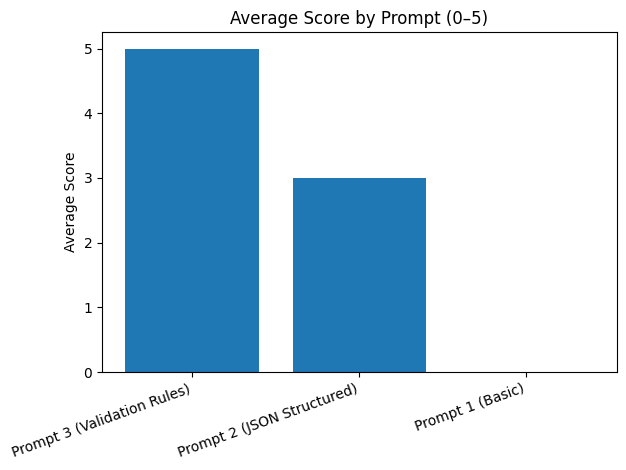

Saved: outputs\summary_avg_score_per_prompt.csv


In [12]:

# Aggregate: average score per prompt
if not results_df.empty and results_df["prompt"].notna().any():
    summary = results_df.groupby("prompt")["score"].mean().reset_index().sort_values("score", ascending=False)
    print(summary)

    # Bar chart (matplotlib, single plot, default colors)
    plt.figure()
    plt.bar(summary["prompt"], summary["score"])
    plt.title("Average Score by Prompt (0–5)")
    plt.ylabel("Average Score")
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()

    # Also export
    summary_path = Path("./outputs/summary_avg_score_per_prompt.csv")
    summary.to_csv(summary_path, index=False)
    print(f"Saved: {summary_path}")
else:
    print("No scored results to summarize.")


                        prompt  score
2  Prompt 3 (Validation Rules)    5.0
1   Prompt 2 (JSON Structured)    3.0
0             Prompt 1 (Basic)    0.0


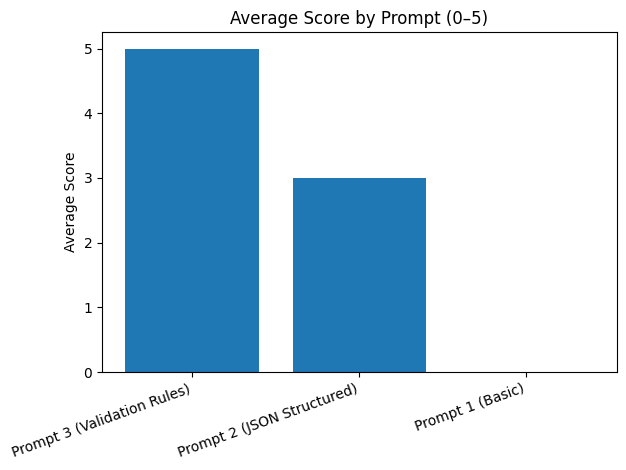

Saved: outputs\summary_avg_score_per_prompt.csv


In [13]:

# Aggregate: average score per prompt
if not results_df.empty and results_df["prompt"].notna().any():
    summary = results_df.groupby("prompt")["score"].mean().reset_index().sort_values("score", ascending=False)
    print(summary)

    # Bar chart (matplotlib, single plot, default colors)
    plt.figure()
    plt.bar(summary["prompt"], summary["score"])
    plt.title("Average Score by Prompt (0–5)")
    plt.ylabel("Average Score")
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()

    # Also export
    summary_path = Path("./outputs/summary_avg_score_per_prompt.csv")
    summary.to_csv(summary_path, index=False)
    print(f"Saved: {summary_path}")
else:
    print("No scored results to summarize.")


                        prompt  score
2  Prompt 3 (Validation Rules)    5.0
1   Prompt 2 (JSON Structured)    3.0
0             Prompt 1 (Basic)    0.0


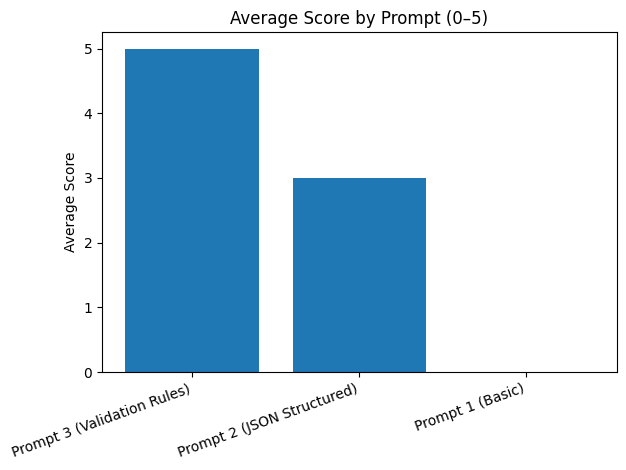

Saved: outputs\summary_avg_score_per_prompt.csv


In [14]:

# Aggregate: average score per prompt
if not results_df.empty and results_df["prompt"].notna().any():
    summary = results_df.groupby("prompt")["score"].mean().reset_index().sort_values("score", ascending=False)
    print(summary)

    # Bar chart (matplotlib, single plot, default colors)
    plt.figure()
    plt.bar(summary["prompt"], summary["score"])
    plt.title("Average Score by Prompt (0–5)")
    plt.ylabel("Average Score")
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()

    # Also export
    summary_path = Path("./outputs/summary_avg_score_per_prompt.csv")
    summary.to_csv(summary_path, index=False)
    print(f"Saved: {summary_path}")
else:
    print("No scored results to summarize.")



## Notes & Tips

- If your PDFs are **scanned images**, run OCR first (see optional OCR cell comments).
- You can **tighten validation** by adding checks for `due_date` format, amount range, or regex for invoice numbers.
- Consider **few-shot prompting**: add 1–2 example invoice texts with ideal JSON outputs to improve consistency.
- For multilingual invoices, add **language normalization** steps (e.g., map `Rechnungsnr.` to `invoice_number`).

---

**Artifacts written to `./outputs/`:**
- `scored_results.csv` — per-file per-prompt scores & flags
- `raw_outputs.json` — full raw and parsed outputs


## Insights and Recommendations


### Insights
- **Prompt 1 (Basic) → score 0**: Free-form instruction produced prose, not JSON. Fails strict validation end-to-end.
- **Prompt 2 (JSON Structured) → score 3**: JSON schema request worked, but lacked normalization rules:
  - **Date** not ISO (`"03 Februar 2025"`).
  - **Amount** not numeric per spec (European comma `"18,90"` vs required dot).
- **Prompt 3 (Validation Rules) → score 5**: Adding explicit formatting and fallback rules (ISO date, numeric amount, `"N/A"`) yielded fully compliant JSON.

### Recommendations
- **Enforce JSON-only output**
  - “Return only a JSON object, no explanations, no markdown.”
  - Provide exact keys and disallow extras.
- **Add explicit normalization rules**
  - **Dates**: ISO `YYYY-MM-DD` only.
  - **Amounts**: digits with optional dot (no commas, no symbols).
  - **Currency**: 3-letter uppercase ISO code.
  - **Missing values**: output `"N/A"`.
- **Use strong delimiters**
  - Wrap invoice text in triple backticks and refer to it explicitly.
- **Require self-check**
  - Ask the model to verify each field against the rules and silently fix before returning.
- **Few-shot with locale variance**
  - Include one example that converts European formats (e.g., `18,90 €` → `"18.90", "EUR"`).
- **Model/SDK aids (optional)**
  - Use `response_format` as JSON if supported to reduce formatting drift.
  - Keep temperature low for deterministic extraction.

### Suggested improved prompt template
```text
You are an invoice extraction assistant. Return ONLY a JSON object with these keys:
{
  "invoice_number": "",
  "invoice_date": "",
  "supplier": "",
  "customer": "",
  "total_amount": "",
  "currency": "",
  "due_date": ""
}

Rules:
- Dates: ISO format YYYY-MM-DD only.
- Amounts: numeric with dot as decimal separator (e.g., 1234.56), no commas or symbols.
- Currency: 3-letter uppercase code (e.g., EUR, USD).
- If a field is missing, use "N/A".
- Do not include any text outside the JSON object.

Before answering, verify all rules are met; if not, fix them silently.

Invoice text:
```
{invoice_text}
```
```

- **Why this works**: Combines structure, strict formatting, normalization, and self-check—replicating the success of Prompt 3 while guarding against locale-induced errors seen in Prompt 2.

- The results are saved in `outputs/raw_outputs.json` and `outputs/scored_results.csv`; your best-performing design is clearly the “Validation Rules” style.

- **Structured output (OpenAI)**
Use __structured output__ whenever you need a structured output in json!
  - **JSON mode**: Force valid JSON with `response_format={"type": "json_object"}` to eliminate prose drift.
  - **JSON Schema / function calling**: Define the exact schema (types, required fields, enums) so the model returns strictly validated fields.

```python
# JSON mode (simple, effective)
resp = client.chat.completions.create(
  model=MODEL_NAME,
  response_format={"type": "json_object"},
  messages=[
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": prompt},
  ],
)
```

```python
# Function calling with a strict schema
resp = client.chat.completions.create(
  model=MODEL_NAME,
  tools=[{
    "type": "function",
    "function": {
      "name": "set_invoice",
      "parameters": {
        "type": "object",
        "properties": {
          "invoice_number": {"type": "string"},
          "invoice_date": {"type": "string", "pattern": "^\\d{4}-\\d{2}-\\d{2}$"},
          "supplier": {"type": "string"},
          "customer": {"type": "string"},
          "total_amount": {"type": "string", "pattern": "^\\d+(\\.\\d+)?$"},
          "currency": {"type": "string", "pattern": "^[A-Z]{3}$"},
          "due_date": {"type": "string"}
        },
        "required": ["invoice_number","invoice_date","supplier","customer","total_amount","currency","due_date"]
      }
    }
  }],
  tool_choice={"type": "function", "function": {"name": "set_invoice"}},
  messages=[{"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt}]
)
```

- **Why use structured output**: Improves reliability, enforces formatting rules (dates, amounts, currency), and reduces prompt brittleness—amplifying the gains seen with your validation-style prompt.